In [1]:
# jupyter setup boilerplate
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from tqdm.auto import tqdm
from scipy.optimize import curve_fit

from qick import *

# for now, all the tProc v2 classes need to be individually imported (can't use qick.*)

# the main program class
from qick.asm_v2 import AveragerProgramV2
# for defining sweeps
from qick.asm_v2 import QickSweep1D

In [2]:
# # to start a pyro server, just uncomment+run this cell

# from qick_training import *
# from qick.pyro import start_server
# # start_server(ns_host="localhost", ns_port=8888, proxy_name="myqick")
# start_server(ns_host="localhost", ns_port=8888, proxy_name="myqick",
#              soc_class=QickTrainingSoc,
#              bitfile="../../fw/2024-07-17_4x2_tprocv2r20_kidsim/qick_4x2.bit")

In [3]:
# # to connect to a pyro server, uncomment and run this cell, skip the next cell
# from qick.pyro import make_proxy
# soc, soccfg = make_proxy(ns_host="pynq4x2.dhcp.fnal.gov", ns_port=8888, proxy_name="myqick")
# print(soccfg)

In [4]:
from qick_training import *

# soc = QickTrainingSoc(bitfile="/data/fw/2024-07-15_216_tprocv2r20_kidsim-dynROv1-2/qick_216.bit")
soc = QickTrainingSoc(bitfile="../../fw/2024-07-17_4x2_tprocv2r20_kidsim/qick_4x2.bit")

soccfg = soc
print(soccfg)

QICK running on RFSoC4x2, software version 0.2.268

Firmware configuration (built Wed Jul 17 14:14:58 2024):

	Global clocks (MHz): tProcessor 614.400, RF reference 491.520

	1 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 2, blk 0 is DAC_A

	1 readout channels:
	0:	axis_dyn_readout_v1 - configured by tProc output 1
		fs=2457.600 MHz, decimated=307.200 MHz, 32-bit DDS, range=2457.600 MHz
		maxlen 16384 accumulated, 16384 decimated (53.333 us)
		triggered by tport 0, pin 0, feedback to tProc input 0
		ADC tile 0, blk 0 is ADC_D

	16 digital output pins:
	0:	PMOD0_0
	1:	PMOD0_1
	2:	PMOD0_2
	3:	PMOD0_3
	4:	PMOD0_4
	5:	PMOD0_5
	6:	PMOD0_6
	7:	PMOD0_7
	8:	Resonator 0
	9:	Resonator 1
	10:	Resonator 2
	11:	Resonator 3
	12:	Resonator 4
	13:	Resonator 5
	14:	Resonator 6
	15:	Resonator 7

	tProc qick_processor ("v2") rev 20: program memory 256 words, data memory 256 wor

In [5]:
RO_CH = 0

In [6]:
soc.config_resonator(verbose=True)

SimuChain: f = 500.0 MHz, fd = -114.39999999999998 MHz, k = 232, fdds = 0.8000000000000114 MHz
AxisKidsimV3: sel        = resonator
AxisKidsimV3: channel    = 232
AxisKidsimV3: lane       = 0
AxisKidsimV3: punct_id   = 29
AxisKidsimV3: iir_c0     = 0.99
AxisKidsimV3: iir_c1     = 0.8
AxisKidsimV3: iir_g      = 0.9045226130653267
AxisKidsimV3: dds_freq   = 0.8000000000000114
AxisKidsimV3: dds_wait   = 95
AxisKidsimV3: sweep_freq = 2.0
AxisKidsimV3: sweep_time = 10.0
AxisKidsimV3: nstep      = 1
freq = 5461, bval = 13653, slope = 13653, steps = 1, wait = 95
c0 = 32440, c1 = 26214, g = 29639
sel = 0, punct_id = 29, addr = 0


In [7]:
# crank up the logging (optional)
import logging
# logging.basicConfig(level=logging.DEBUG, force=True)
# logging.basicConfig(level=logging.INFO, force=True, format='%(levelname)-8s [%(filename)s:%(lineno)d] %(message)s')
# logging.basicConfig(level=logging.DEBUG, force=True, format='%(levelname)-8s [%(filename)s:%(lineno)d] %(message)s')
logging.basicConfig(level=logging.WARNING, force=True)


In [8]:
# for i in range(0,8):
# #     print(soccfg['tprocs'][0]['output_pins'][4+i])
#     soccfg['tprocs'][0]['output_pins'][4+i] = ('output', 7, 12+i, 'Resonator %d'%(i))
soccfg['tprocs'][0]['output_pins']

[('dport', 0, 0, 'PMOD0_0'),
 ('dport', 0, 1, 'PMOD0_1'),
 ('dport', 0, 2, 'PMOD0_2'),
 ('dport', 0, 3, 'PMOD0_3'),
 ('dport', 0, 4, 'PMOD0_4'),
 ('dport', 0, 5, 'PMOD0_5'),
 ('dport', 0, 6, 'PMOD0_6'),
 ('dport', 0, 7, 'PMOD0_7'),
 ('dport', 1, 0, 'Resonator 0'),
 ('dport', 1, 1, 'Resonator 1'),
 ('dport', 1, 2, 'Resonator 2'),
 ('dport', 1, 3, 'Resonator 3'),
 ('dport', 1, 4, 'Resonator 4'),
 ('dport', 1, 5, 'Resonator 5'),
 ('dport', 1, 6, 'Resonator 6'),
 ('dport', 1, 7, 'Resonator 7')]

  0%|          | 0/1 [00:00<?, ?it/s]

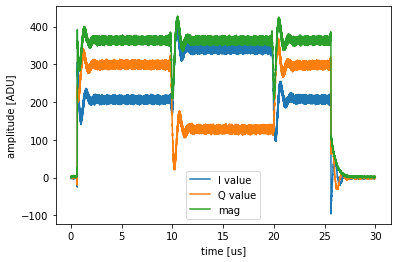

In [9]:
class ResTestProgram(AveragerProgramV2):
    def initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'])
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['freq'], gen_ch=gen_ch)

        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch, 
                       style="const", 
#                        mode='periodic',
                       freq=cfg['freq'], 
                       length=cfg['pulse_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'], 
                      )
        
        # trigger the resonator and the DDR4 buffer
        self.trigger(ddr4=True, mr=True, t=0)
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        
    def body(self, cfg):
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0)
        if cfg['do_jump']:
            self.trigger(pins=list(range(8,16)), t=cfg['t_jump'])
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

# do a sweep with 5 points and plot decimated
config = {'gen_ch': 0,
          'ro_ch': RO_CH,
          'freq': 499.0,
          'nqz': 1,
          'trig_time': 3.0,
          'do_jump' : True,
          't_jump' : 10,
          'ro_len': 30,
          'pulse_len': 25,
          'phase': 0,
          'gain': 1.0,
#           'gain': 0.05,
         }

prog = ResTestProgram(soccfg, reps=1, final_delay=10.0, cfg=config)


# Arm the buffers
soc.arm_mr(ch=RO_CH)
n_transfers = 100000 # each transfer (aka burst) is 256 decimated samples
soc.arm_ddr4(ch=RO_CH, nt=n_transfers)

iq_list = prog.acquire_decimated(soc, soft_avgs=1)
t = prog.get_time_axis(ro_index=0)

iq=iq_list[0]
plt.plot(t, iq[:,0], label="I value")
plt.plot(t, iq[:,1], label="Q value")
plt.plot(t, np.abs(iq.dot([1,1j])), label="mag")
plt.legend()
plt.ylabel("amplitude [ADU]")
plt.xlabel("time [us]");

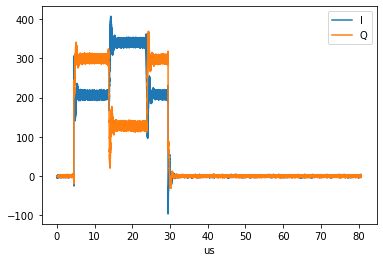

In [10]:
iq_ddr4 = soc.get_ddr4(100)
t = prog.get_time_axis_ddr4(0, iq_ddr4)

plt.plot(t, iq_ddr4[:,0],label="I")
plt.plot(t, iq_ddr4[:,1],label="Q")
# plt.plot(np.abs(iq_ddr4.dot([1,1j])),label="mag")
plt.xlabel("us")
plt.legend();

In [11]:
# soc.clear_ddr4()

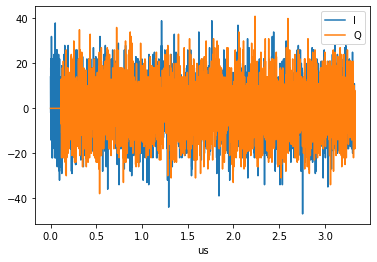

In [12]:
# look at the MR buffer just to see it works
iq_mr = soc.get_mr()
t = prog.get_time_axis_mr(0, iq_mr)
plt.plot(t, iq_mr[:,0],label="I")
plt.plot(t, iq_mr[:,1],label="Q")
plt.xlabel("us")
plt.legend();

In [13]:
# let's play some max-power pulses far from the resonance, to make sure we're not saturating the simulator
START_FREQ = 495
CAL_RANGE = 0.1
END_FREQ = 505

# START_FREQ = 100
# CAL_RANGE = 1
# END_FREQ = 2000

class FreqSweepProgram(AveragerProgramV2):
    def initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'])
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        self.add_loop("myloop", self.cfg["steps"])
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['freq'], gen_ch=gen_ch)

        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch, 
#                        style="flat_top", 
                       style="const", 
#                        envelope="ramp",
                       freq=cfg['freq'], 
                       length=cfg['flat_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'], 
                      )
#         self.trigger(pins=list(range(8,16)),t=0)
        
    def body(self, cfg):
        # if you delay the config by too long, you can see the readout get reconfigured in the middle of your pulse
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

# do a sweep with 5 points and plot decimated
config = {'steps': 5,
          'gen_ch': 0,
          'ro_ch': RO_CH,
          'freq': QickSweep1D("myloop", START_FREQ, START_FREQ+CAL_RANGE),
          'nqz': 1,
          'trig_time': 3.0,
          'ro_len': 7,
          'flat_len': 5.0,
          'phase': 0,
          'gain': 1.0,
         }

prog = FreqSweepProgram(soccfg, reps=1, final_delay=10.0, cfg=config)

iq_list = prog.acquire_decimated(soc, soft_avgs=1)
t = prog.get_time_axis(ro_index=0)

  0%|          | 0/1 [00:00<?, ?it/s]

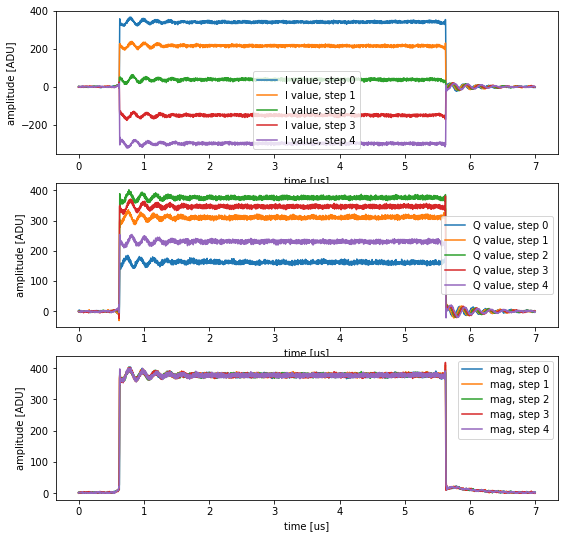

In [14]:
fig, axes = plt.subplots(3, 1, figsize=(9,9))
for ii, iq in enumerate(iq_list[0]):
    axes[0].plot(t, iq[:,0], label="I value, step %d"%(ii))
    axes[1].plot(t, iq[:,1], label="Q value, step %d"%(ii))
    axes[2].plot(t, np.abs(iq.dot([1,1j])), label="mag, step %d"%(ii))
for plot in axes:
    plot.legend()
    plot.set_ylabel("amplitude [ADU]")
    plot.set_xlabel("time [us]");

  0%|          | 0/100010 [00:00<?, ?it/s]

phase step (cycles): -0.00015730204805983194
relative delay 3.2714 us


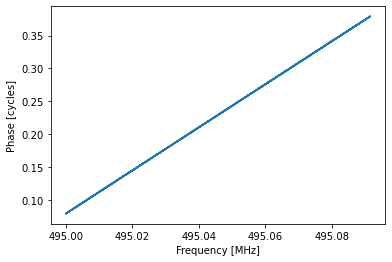

In [15]:
# config['steps']=100001
config['steps']=10001

prog = FreqSweepProgram(soccfg, reps=10, final_delay=1.0, cfg=config)
freqs = prog.get_pulse_param('myro', 'freq', as_array=True)
iq_list = prog.acquire(soc, soft_avgs=1, progress=True)
# plt.plot(np.angle(iq_list[0][0].dot([1,1j]), deg=True))

# plt.plot(iq_list[0][0,:,0], iq_list[0][0,:,1], '.')
# plt.ylabel("Q [ADU]")
# plt.xlabel("I [ADU]");

iq_complex = iq_list[0][0].dot([1,1j])
phases = np.unwrap(np.angle(iq_complex))/(2*np.pi)

plt.plot(freqs, phases)
plt.ylabel("Phase [cycles]")
plt.xlabel("Frequency [MHz]")

print("phase step (cycles):", phases[1]-phases[0])

a = np.vstack([freqs, np.ones_like(freqs)]).T
phase_delay = np.linalg.lstsq(a, phases, rcond=None)[0][0]
print("relative delay %.4f us"%(phase_delay))

  0%|          | 0/100010 [00:00<?, ?it/s]

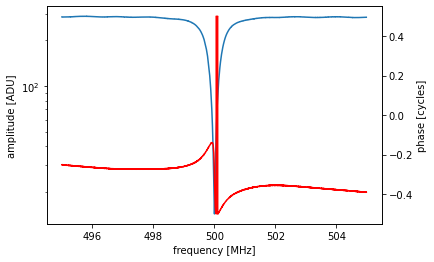

In [16]:
config['freq'] = QickSweep1D("myloop", START_FREQ, END_FREQ)
# config['freq'] = QickSweep1D("myloop", 552, 562)

config['steps'] = 10001
# freqs = np.linspace(START_FREQ, END_FREQ, config['steps'])

prog = FreqSweepProgram(soccfg, reps=10, final_delay=10.0, cfg=config)
freqs = prog.get_pulse_param('myro', 'freq', as_array=True)
iq_list = prog.acquire(soc, soft_avgs=1, progress=True)
iq_complex = iq_list[0][0].dot([1,1j])

iq_rotated = iq_complex*np.exp(-1j*freqs*2*np.pi*phase_delay)

# plt.plot(np.real(iq_rotated), np.imag(iq_rotated))
# plt.ylabel("Q [ADU]")
# plt.xlabel("I [ADU]");

# phases_corrected = np.unwrap(np.angle(iq_rotated))/(2*np.pi)
phases_corrected = np.angle(iq_rotated)/(2*np.pi)

fig, plot = plt.subplots()
plot.semilogy(freqs, np.abs(iq_rotated), label="amplitude")
ax2 = plot.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(freqs, phases_corrected, color='red', label='phase')

plot.set_ylabel("amplitude [ADU]")
plot.set_xlabel("frequency [MHz]")
ax2.set_ylabel("phase [cycles]");

pole-zero fit: [556.54809411   0.98994287   0.79636945 286.03475232]


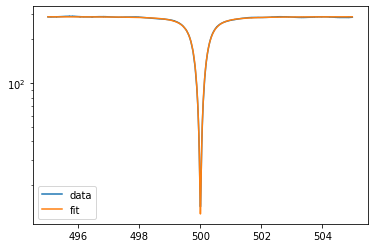

In [17]:
# fit a pole-zero function to the magnitude
# gives a good fit, though we clearly don't know how to normalize the parameters correctly
# we could do a complex fit, but don't need to

def polezero(f, f0, c0, c1, G):
    f_scale = 1.5 # this is probably related to the time interval used in the IIR or something
    z = np.exp(1j*f/f_scale)
    # leo applies an overall G0 = (1+c1)/(1+c0) which seems to normalize to 1 far from the resonance
    G0 = (1+c1)/(1+c0)
    return G*G0*np.abs((z-c0*np.exp(1j*f0/f_scale))/(z-c1*np.exp(1j*f0/f_scale)))

mags = np.abs(iq_rotated)
plt.semilogy(freqs, mags, label='data')

guess = [557, 0.9, 0.8, np.max(mags)]
popt, pcov = curve_fit(polezero, freqs, mags, maxfev = 100000, p0 = guess)
fit_polezero = polezero(freqs, *popt)
# plt.semilogy(freqs, polezero(freqs, *guess), label='guess')
plt.semilogy(freqs, fit_polezero, label='fit')
plt.legend()

print("pole-zero fit:", popt)

In [18]:
soc.config_resonator(c0=0.9, c1=0.3, verbose=True)

SimuChain: f = 500.0 MHz, fd = -114.39999999999998 MHz, k = 232, fdds = 0.8000000000000114 MHz
AxisKidsimV3: sel        = resonator
AxisKidsimV3: channel    = 232
AxisKidsimV3: lane       = 0
AxisKidsimV3: punct_id   = 29
AxisKidsimV3: iir_c0     = 0.9
AxisKidsimV3: iir_c1     = 0.3
AxisKidsimV3: iir_g      = 0.6842105263157895
AxisKidsimV3: dds_freq   = 0.8000000000000114
AxisKidsimV3: dds_wait   = 95
AxisKidsimV3: sweep_freq = 2.0
AxisKidsimV3: sweep_time = 10.0
AxisKidsimV3: nstep      = 1
freq = 5461, bval = 13653, slope = 13653, steps = 1, wait = 95
c0 = 29491, c1 = 9830, g = 22420
sel = 0, punct_id = 29, addr = 0


  0%|          | 0/1 [00:00<?, ?it/s]

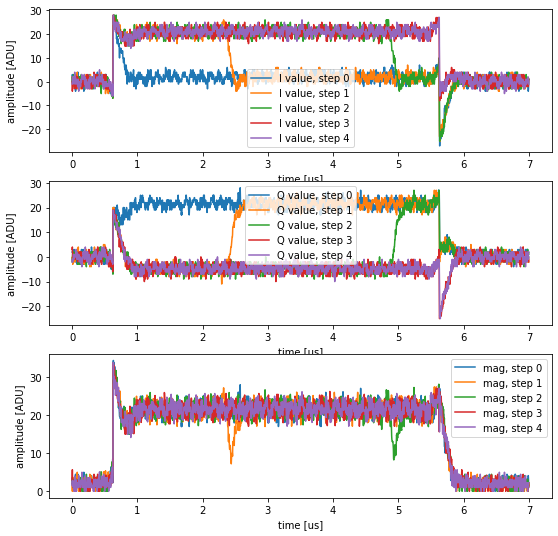

In [19]:
class T1Program(AveragerProgramV2):
    def initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'])
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['freq'], gen_ch=gen_ch)

        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch, 
                       style="const", 
#                        mode='periodic',
                       freq=cfg['freq'], 
                       length=cfg['pulse_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'], 
                      )
        
        self.add_loop("myloop", self.cfg["steps"])
        
        # configure the readout
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        # trigger the special buffers
        self.trigger(ddr4=True, mr=True, t=0)
        
    def body(self, cfg):
        if cfg['do_jump']:
            self.trigger(pins=list(range(8,16)), t=cfg['t_jump'])
            
        self.delay(10)
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=cfg['t_pulse'])
#         self.delay(1)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['t_ro'])
#         self.delay(1)

# do a sweep with 5 points and plot decimated
config = {'gen_ch': 0,
          'ro_ch': RO_CH,
          'freq': 499.0,
          'nqz': 1,
          't_pulse': 0.0,
          't_ro': 3.0,
          'do_jump' : True,
          't_jump' : QickSweep1D("myloop", 0.0, 10.0),
          'steps' : 5,
          'ro_len': 7,
          'pulse_len': 5,
          'phase': 0,
          'gain': 0.1,
#           'gain': 0.05,
         }

prog = T1Program(soccfg, reps=1, final_delay=10.0, cfg=config)


# Arm the buffers
soc.arm_mr(ch=RO_CH)
n_transfers = 100000 # each transfer (aka burst) is 256 decimated samples
soc.arm_ddr4(ch=RO_CH, nt=n_transfers)

iq_list = prog.acquire_decimated(soc, soft_avgs=1)
t = prog.get_time_axis(ro_index=0)

fig, axes = plt.subplots(3, 1, figsize=(9,9))
for ii, iq in enumerate(iq_list[0]):
    axes[0].plot(t, iq[:,0], label="I value, step %d"%(ii))
    axes[1].plot(t, iq[:,1], label="Q value, step %d"%(ii))
    axes[2].plot(t, np.abs(iq.dot([1,1j])), label="mag, step %d"%(ii))
for plot in axes:
    plot.legend()
    plot.set_ylabel("amplitude [ADU]")
    plot.set_xlabel("time [us]");

In [20]:
iq.shape

(2150, 2)